In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [5]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


### Get ANOVA table

In [7]:
def get_ANOVA_table(df):
  [b0, b1], df_residual = get_regress_coeff(df)

  # calculation sum of squares total
  df_residual["meanY"] = df_residual['Y'].mean()
  df_residual["(Y - meanY)"] = df_residual['Y'] - df_residual["meanY"]
  df_residual["(Y - meanY)^2"] = df_residual['(Y - meanY)']**2

  # calculation sum of squares error
  df_residual['hat_Y'] = b0 + b1*df_residual['X']
  df_residual['(Y - hat_Y)'] = df_residual['Y'] - df_residual["hat_Y"]
  df_residual['(Y - hat_Y)^2'] = df_residual['(Y - hat_Y)']**2

  # calculation sum of squares regression
  df_residual['(hat_Y - meanY)^2'] = (df_residual['hat_Y'] - df_residual['meanY'])**2

  SST = df_residual["(Y - meanY)^2"].sum()
  SSE = df_residual["(Y - hat_Y)^2"].sum()
  SSR = df_residual["(hat_Y - meanY)^2"].sum()

  num_of_sample = len(df_residual)

  data = [
    ["Regression", SSR, 1                , SSR/1],
    ["Error"     , SSE, num_of_sample - 2, SSE/(num_of_sample - 2)],
    ["Total"     , SST, num_of_sample - 1, None]]
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "Sum of Squares", "d.o.f", "Mean Square"], 
    floatfmt=(None, ".2f", None, ".2f"))


  return anova_table, df_residual 

## Load the data

In [8]:
filename = "05-table-01-milk-gallons.ods"

df = read_ods(filename)

df

,Week,"Weekly Sales Level, Y (1,000s of gallons)",Selling Price X ($)
0,1,10,1.3
1,2,6,2.0
2,3,5,1.7
3,4,12,1.5
4,5,10,1.6
5,6,15,1.2
6,7,5,1.6
7,8,12,1.4
8,9,17,1.0
9,10,20,1.1


## Compute least squares coefficients ($b_1$ and $b_0$)

$$
\begin{gather*}
  b_1 = \frac{n \sum XY - \sum X \sum Y}{n \sum X^2 - (\sum X)^2} \\[12pt]
  b_0 = \frac{\sum Y}{n} - \frac{b_1 \sum X}{n}
\end{gather*}
$$

In [9]:
df_corr = df.copy()

# rename the corresponding X and Y column
df_corr = df_corr.rename(columns={
  "Weekly Sales Level, Y (1,000s of gallons)": 'Y',
  "Selling Price X ($)": 'X'})

[b0, b1], df_corr = get_regress_coeff(df_corr)

print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
df_corr

(b0, b1) = (32.14, -14.54)


,Week,Y,X,XY,X^2
0,1,10,1.3,13.0,1.69
1,2,6,2.0,12.0,4.00
2,3,5,1.7,8.5,2.89
3,4,12,1.5,18.0,2.25
4,5,10,1.6,16.0,2.56
5,6,15,1.2,18.0,1.44
6,7,5,1.6,8.0,2.56
7,8,12,1.4,16.8,1.96
8,9,17,1.0,17.0,1.00
9,10,20,1.1,22.0,1.21


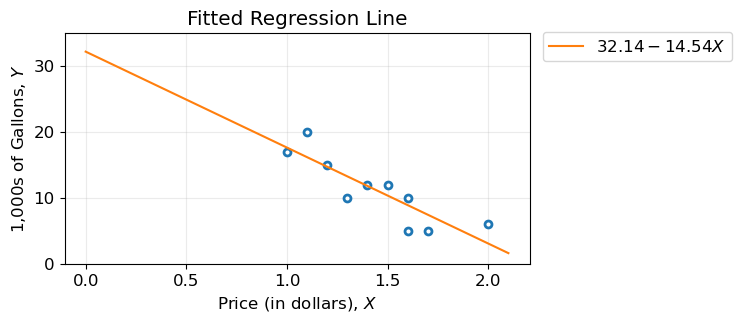

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_regress = np.linspace(0, 2.1)
ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 

ax.set_ylim([0, 35])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Compute ANOVA table

In [11]:
df_anova = df.copy()

# rename the corresponding X and Y column
df_anova = df_anova.rename(columns={
  "Weekly Sales Level, Y (1,000s of gallons)": 'Y',
  "Selling Price X ($)": 'X'})

anova_table, df_residual = get_ANOVA_table(df_anova)
df_residual

,Week,Y,X,XY,X^2,meanY,(Y - meanY),(Y - meanY)^2,hat_Y,(Y - hat_Y),(Y - hat_Y)^2,(hat_Y - meanY)^2
0,1,10,1.3,13.0,1.69,11.2,-1.2,1.44,13.235437,-3.235437,10.468052,4.143003
1,2,6,2.0,12.0,4.00,11.2,-5.2,27.04,3.058252,2.941748,8.653879,66.288054
2,3,5,1.7,8.5,2.89,11.2,-6.2,38.44,7.419903,-2.419903,5.855930,14.289134
3,4,12,1.5,18.0,2.25,11.2,0.8,0.64,10.327670,1.672330,2.796688,0.760960
4,5,10,1.6,16.0,2.56,11.2,-1.2,1.44,8.873786,1.126214,1.268357,5.411270
5,6,15,1.2,18.0,1.44,11.2,3.8,14.44,14.689320,0.310680,0.096522,12.175357
6,7,5,1.6,8.0,2.56,11.2,-6.2,38.44,8.873786,-3.873786,15.006221,5.411270
7,8,12,1.4,16.8,1.96,11.2,0.8,0.64,11.781553,0.218447,0.047719,0.338204
8,9,17,1.0,17.0,1.00,11.2,5.8,33.64,17.597087,-0.597087,0.356513,40.922727
9,10,20,1.1,22.0,1.21,11.2,8.8,77.44,16.143204,3.856796,14.874876,24.435265


In [12]:
anova_table

Source,Sum of Squares,d.o.f,Mean Square
Regression,174.18,1,174.18
Error,59.42,8,7.43
Total,233.60,9,
